In [1]:
# importing libraries
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from datetime import date, timedelta
from pandas import DataFrame
import sqlalchemy as sq
import numpy as np
from sklearn.model_selection import train_test_split
import math
import time
import scipy as scipy
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from ggplot import *
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import gc

Using Theano backend.


In [2]:
data=pd.read_csv('/data/pratik/tensor/ad_clean.csv',error_bad_lines=False)

In [3]:
bag_summary=data.groupby(['brand','article_type','gender']).agg({'qty_sold' : np.sum})
bag_summary.reset_index(inplace=True)
bag_summary.sort_values(by='qty_sold',ascending=False).head(n=10)

brand  article_type gender  qty_sold
12280               Roadster       Tshirts    Men    481175
12261               Roadster        Shirts    Men    284597
1215                   Anouk        Kurtas  Women    142702
9568             Moda Rapido       Tshirts    Men    140019
12232               Roadster  Casual Shoes    Men    128356
12247               Roadster         Jeans    Men    122134
15699                      W        Kurtas  Women    121782
263                      AKS        Kurtas  Women    118251
8392                   Libas        Kurtas  Women    118011
6141   HRX by Hrithik Roshan       Tshirts    Men    100348

In [4]:
ad=data[(data['brand']=='Moda Rapido') & (data['article_type']=='Tshirts') & (data['gender']=='Men') ]

In [5]:
ad.sort_values(by='date',inplace=True)
ad['input_td']=ad['input_td'].clip(ad['input_td'].quantile(0.02),ad['input_td'].quantile(0.98))
ad['lp_screens']=ad['lp_screens'].clip(ad['lp_screens'].quantile(0.02),ad['lp_screens'].quantile(0.98))
ad['pi_lag']=ad['pi_score'].shift(1)
ad['pi_rm']=ad['pi_score'].rolling(15, min_periods=1).mean()
ad['input_td_diff']=ad['input_td']/ad['input_td'].rolling(15, min_periods=1).mean()
ad['output_td_diff']=ad['output_td']/ad['output_td'].rolling(15, min_periods=1).mean()
ad['vis_tr']=ad['lc_share_pltf']*ad['sessions']/100
ad[['pi_score','pi_lag','pi_rm']]

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pi_score       pi_lag        pi_rm
136020   1795.230027          NaN  1795.230027
173959   2699.175166  1795.230027  2247.202596
174370   3685.645186  2699.175166  2726.683460
213630   2228.616195  3685.645186  2602.166644
213269   2923.516705  2228.616195  2666.436656
22710    2372.382104  2923.516705  2617.427564
135612   3427.887592  2372.382104  2733.207568
4101     2525.448315  3427.887592  2707.237661
214296   2736.379880  2525.448315  2710.475686
298054   3583.243759  2736.379880  2797.752493
213993   2943.127351  3583.243759  2810.968389
214528   3300.309476  2943.127351  2851.746813
46234    3319.321007  3300.309476  2887.714059
8317     2811.982157  3319.321007  2882.304637
25450    3545.261596  2811.982157  2926.501768
418440   3330.211840  3545.261596  3028.833889
378057   3951.376466  3330.211840  3112.313975
339154   3013.366868  3951.376466  3067.495421
14991    2770.760529  3013.366868  3103.638376
27086    1693.326941  2770.760529  3021.625725
52162    2133.934650  1693.326941  3005.729228
337848   2583.734063  2133.934650  2949.452327
502380   2335.513525  2583.734063  2936.790007
102580   1946.883953  2335.513525  2884.156945
542944   2527.959439  1946.883953  2813.804657
542964   2210.868888  2527.959439  2764.987427
461457   2802.271887  2210.868888  2731.784921
502943   2655.239431  2802.271887  2687.512816
73387    3131.309064  2655.239431  2708.801276
462244   3669.789612  3131.309064  2717.103144
...              ...          ...          ...
1549182  2225.402018  1811.132911  2779.730218
1476026  2341.851612  2225.402018  2758.663539
1502707  2050.422915  2341.851612  2731.634825
1075605  2351.782957  2050.422915  2733.441232
1526289  1943.312742  2351.782957  2704.723847
1043876  2298.805655  1943.312742  2728.175254
1718671  1945.733221  2298.805655  2734.072539
1802530  1889.817742  1945.733221  2593.342392
1679443  2308.638382  1889.817742  2497.951537
1755149  1747.910642  2308.638382  2414.999427
1679454  1986.222538  1747.910642  2175.034939
1755382  2043.217423  1986.222538  2150.616677
1802932  2094.416771  2043.217423  2110.495684
1655106  2152.847904  2094.416771  2079.434362
1688947  2767.560210  2152.847904  2143.196182
1845504  2498.757710  2767.560210  2161.419895
1718789  2034.136657  2498.757710  2140.905565
1691433  2066.313730  2034.136657  2141.964952
1655151  2513.609845  2066.313730  2152.753411
1754790  2848.473279  2513.609845  2213.097447
1718852  2116.901437  2848.473279  2200.970499
1802435  2293.581271  2116.901437  2224.160369
1651426  2173.182887  2293.581271  2243.051379
1755290  2095.867289  2173.182887  2228.866639
1802506  2302.636700  2095.867289  2265.848377
1684805  2074.254691  2302.636700  2271.717187
1802019  2237.492300  2074.254691  2284.668845
1683042  1870.496589  2237.492300  2269.740833
1718506   285.200137  1870.496589  2145.230982
1845819     0.000000   285.200137  1960.726968

[163 rows x 3 columns]

In [6]:
univariate=ad.describe(percentiles=[.01,.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99]).transpose()
univariate

count          mean            std           min  \
date                 163.0  2.017036e+07     162.296162  2.017011e+07   
qty_sold             163.0  8.590123e+02     198.631180  4.260000e+02   
live_styles          163.0  5.565337e+02      52.963682  2.560000e+02   
list_count           163.0  1.859701e+06  574287.519136  5.413430e+05   
inventory            163.0  5.126231e+04   11680.189652  2.162400e+04   
input_td             163.0  2.399387e+01       6.106561  1.500000e+01   
output_td            163.0  1.976283e-01       0.053022  1.018217e-01   
output_cd            163.0  8.823497e-03       0.014700  1.580489e-04   
return_perc          163.0  1.281988e-01       0.058890  0.000000e+00   
lp_screens           163.0  1.917252e+01      10.715600  0.000000e+00   
pi_score             163.0  2.792708e+03     784.919580  0.000000e+00   
brokeness            163.0  3.331040e-01       0.074121  5.611222e-02   
freshness            163.0  3.338363e-01       0.152755  9.523810e-02   
styles_age_0_30      163.0  1.351060e-01       0.060522  4.159734e-02   
styles_age_31_60     163.0  1.323928e-01       0.055227  2.360515e-02   
styles_age_61_90     163.0  1.084913e-01       0.063899  8.658009e-03   
styles_age_91_120    163.0  8.379374e-02       0.067015  0.000000e+00   
styles_age_121_150   163.0  9.489236e-02       0.136282  0.000000e+00   
styles_age_180plus   163.0  2.882818e-01       0.170813  6.302521e-03   
lp_pdp_conversion    163.0  2.261877e-02       0.004282  1.277055e-02   
lc_share_ag          163.0           inf            NaN  1.425383e-02   
lc_share_pltf        163.0  3.484645e-01       0.128305  7.730079e-02   
lc_share_ag_to_pltf  143.0  4.783408e-02       0.006531  3.261693e-02   
sessions             163.0  3.337456e+06  448688.430821  2.697287e+06   
pi_lag               162.0  2.809947e+03     755.767199  2.852001e+02   
pi_rm                163.0  2.830245e+03     429.146301  1.795230e+03   
input_td_diff        163.0  9.807610e-01       0.095837  7.812500e-01   
output_td_diff       163.0  9.684033e-01       0.139706  7.019754e-01   
vis_tr               163.0  1.138201e+04    3779.969069  2.912330e+03   

                               1%            5%           10%           15%  \
date                 2.017011e+07  2.017011e+07  2.017012e+07  2.017015e+07   
qty_sold             4.594800e+02  6.030000e+02  6.472000e+02  6.692000e+02   
live_styles          4.258400e+02  4.660000e+02  5.062000e+02  5.183000e+02   
list_count           7.354084e+05  1.144437e+06  1.223080e+06  1.302830e+06   
inventory            3.340954e+04  3.715490e+04  4.059480e+04  4.219230e+04   
input_td             1.500000e+01  1.510000e+01  1.600000e+01  1.700000e+01   
output_td            1.126063e-01  1.259980e-01  1.307557e-01  1.361959e-01   
output_cd            2.902735e-04  8.243550e-04  9.705356e-04  1.111866e-03   
return_perc          0.000000e+00  0.000000e+00  4.958102e-03  3.468359e-02   
lp_screens           0.000000e+00  0.000000e+00  0.000000e+00  2.700000e+00   
pi_score             9.775285e+02  1.815747e+03  1.945963e+03  2.066707e+03   
brokeness            6.379290e-02  1.803416e-01  1.997721e-01  2.874780e-01   
freshness            1.047515e-01  1.183654e-01  1.418045e-01  1.494259e-01   
styles_age_0_30      4.239293e-02  5.436549e-02  7.106191e-02  7.690071e-02   
styles_age_31_60     3.530063e-02  4.888973e-02  6.661222e-02  7.123300e-02   
styles_age_61_90     1.465557e-02  1.768543e-02  2.148111e-02  2.581796e-02   
styles_age_91_120    1.937474e-03  2.109329e-03  3.735659e-03  5.626557e-03   
styles_age_121_150   1.834862e-03  1.866020e-03  2.263181e-03  3.874578e-03   
styles_age_180plus   6.391416e-03  7.847778e-03  9.494895e-03  1.129738e-02   
lp_pdp_conversion    1.399318e-02  1.687749e-02  1.766206e-02  1.812709e-02   
lc_share_ag          1.489191e-02  2.829805e-02  3.055657e-02  3.243458e-02   
lc_share_pltf        9.354777e-02  2.005967e-01  2.221716e-01  2.351125e-01   
lc_share_ag_t

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
d=ad[['date','qty_sold','output_td','output_td_diff','pi_rm','lc_share_pltf','lp_screens',
      'output_cd','sessions','brokeness','styles_age_180plus','live_styles','lp_pdp_conversion']]
train, test= train_test_split(d, test_size=0.3, random_state=0)
y_train = train.qty_sold
X_train = train.drop(['qty_sold','date'],axis=1)

y_test = test.qty_sold
X_test = test.drop(['qty_sold','date'],axis=1)

/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: Deprecation

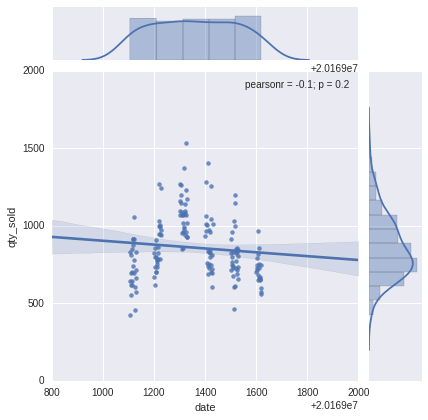

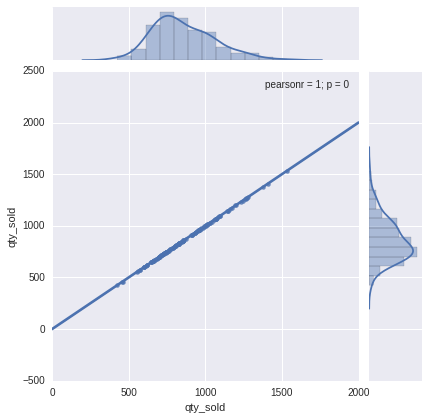

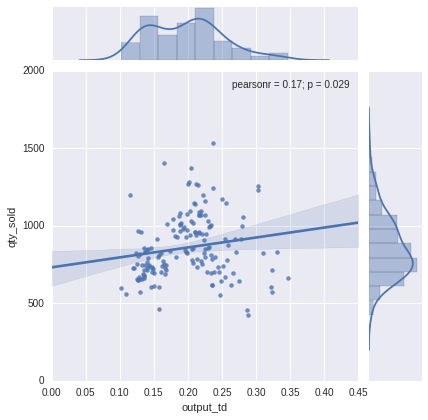

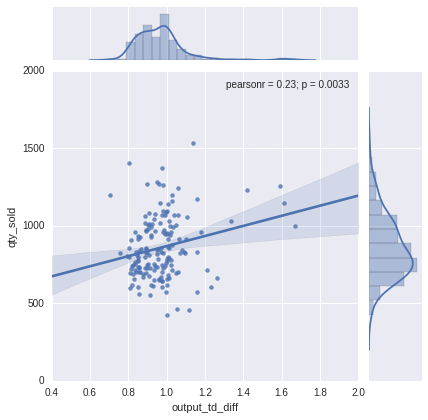

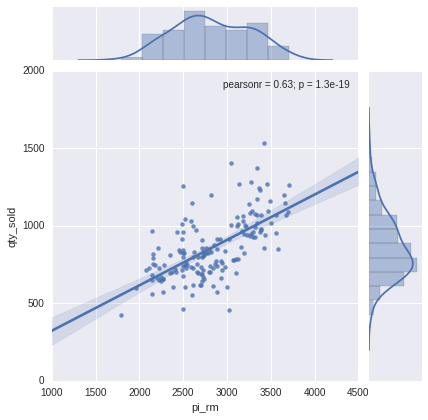

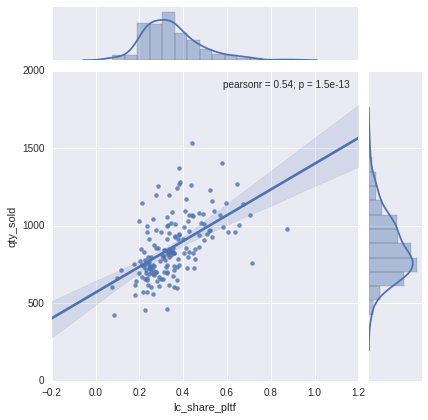

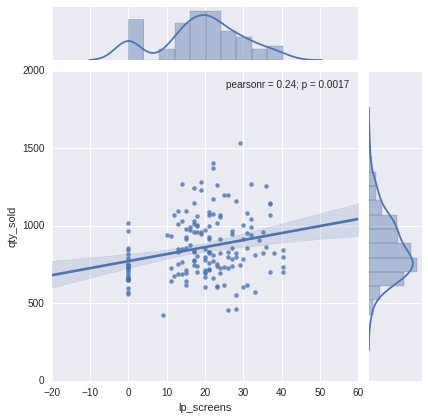

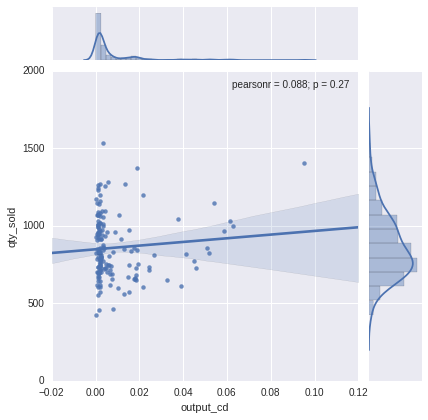

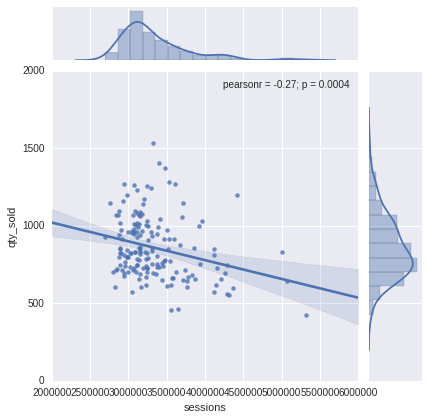

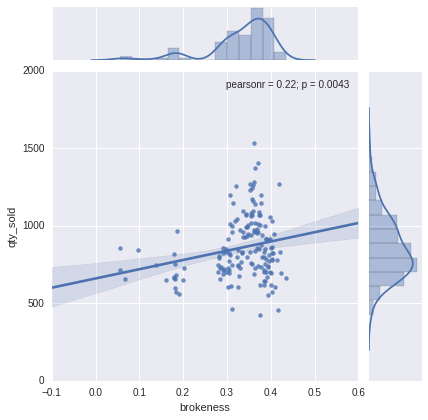

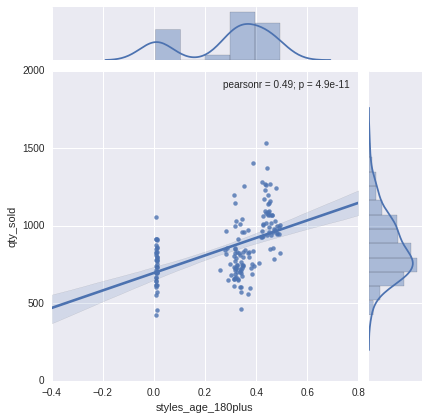

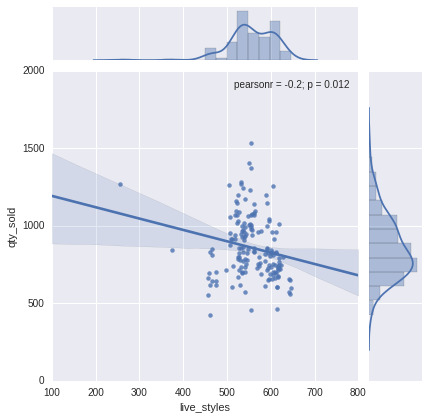

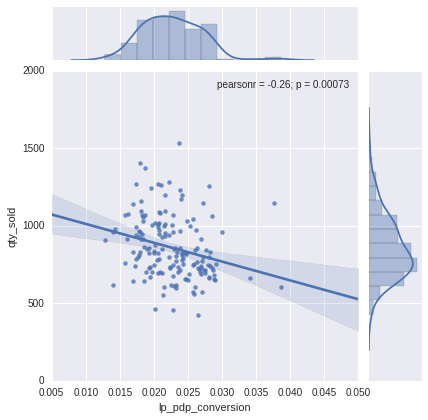

In [9]:
for i in d._get_numeric_data().columns:
    sns.jointplot(x=i, y="qty_sold", data=ad,kind="reg")

In [ ]:
ad.sort_values(by='date',inplace=True)
ad.date = ad.date.astype(str)

bi=ad[['date','qty_sold','styles_age_180plus']]
bi.set_index('date',inplace=True)
#data_roadster_tshirts.plot(x="date", y="total_units",secondary_y="lv_share", kind="line")
bi.plot(subplots=True)

In [8]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scalerX = StandardScaler()  
scalerY = StandardScaler()  
# Don't cheat - fit only on training data
X_tr = scalerX.fit_transform(X_train)
X_te = scalerX.transform(X_test)
# apply same transformation to test data
y_tr = scalerY.fit_transform(y_train)
y_te = scalerY.transform(y_test)

In [ ]:
m8 = Sequential()
m8.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
m8.add(Dense(1, kernel_initializer='normal'))
# Compile model
m8.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
print "Keras NN reg"
m8.fit(X_tr,y_tr)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m8.predict(X_te) - y_te) ** 2)))
# Explained variance score: 1 is perfect prediction
print( 'Training MAPE: %0.2f' % mape(scalerY.inverse_transform(m8.predict(X_tr)), y_train.as_matrix()))
print( 'Validation MAPE: %0.2f' % mape(scalerY.inverse_transform(m8.predict(X_te)), y_test.as_matrix()))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(scalerY.inverse_transform(m8.predict(X_te)),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
m5 = Sequential()
m5.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
m5.add(Dense(5, kernel_initializer='normal', activation='relu'))
m5.add(Dense(1, kernel_initializer='normal'))
# Compile model
m5.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
m5.fit(X_train.as_matrix(),y_train.as_matrix(),epochs=10, batch_size=50)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m5.predict(X_test.as_matrix()) - y_test.as_matrix()) ** 2)))
# Explained variance score: 1 is perfect prediction
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m5.predict(X_train.as_matrix()), y_train.as_matrix()))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m5.predict(X_test.as_matrix()), y_test.as_matrix()))
print( 'Training MAPE: %0.2f' % mape(m5.predict(X_train.as_matrix()), y_train.as_matrix()))
print( 'Validation MAPE: %0.2f' % mape(m5.predict(X_test.as_matrix()), y_test.as_matrix()))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m5.predict(X_test.as_matrix()),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train.as_matrix(), y_train.as_matrix(), cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train.as_matrix(), y_train.as_matrix(), cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu')) # input layer; size 13
    model.add(Dense(5, kernel_initializer='normal', activation='relu')) # hidden layer; size 6
    model.add(Dense(1, kernel_initializer='normal')) # output layer; size 1 with no activation since it's a regression problem
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# evaluation on the larger net
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train.as_matrix(), y_train.as_matrix(), cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train.as_matrix(), y_train.as_matrix(), cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
results